In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel_OneHot'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
# Create list of columns that can reasonably be one-hot-encoded
one_hot_cols = [
    'borough',
    'neighborhood',
    'zip_code',
    'tax_class_at_time_of_sale',
    'tax_class_at_present',
    'tax_class_at_present_prefix',
    'building_class_category',
    'building_class_at_time_of_sale',
    'building_class_at_time_of_sale_prefix',
    'building_class_at_present',
    'building_class_at_present_prefix'
    ]

# Create list of columns that have too many unique values
to_drop = [
    'block',
    'lot',
    'address',
    'apartment_number',
    'street_name'
    ]

In [9]:
# Define dataset parameters
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': to_drop + ['sale_price_adj'],
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': OneHotEncoder(cols=one_hot_cols),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [10]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [11]:
# Define model architecture
class LinearModel_OneHot(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(dataset.X_text.shape[1], 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [12]:
# Instantiate model
model = LinearModel_OneHot().to(device)

In [13]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 804


In [14]:
# Do not traing if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file():
    # Load optimal weights
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.001),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=50,
        patience=50,
        delta=0,
        batch_size=2048,
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 21/21 [00:00<00:00, 54.43it/s]


Epoch  1/50: RMSE_train: 1,702,995, RMSE_val: 1,652,107


100%|██████████| 21/21 [00:00<00:00, 78.33it/s] 


Epoch  2/50: RMSE_train: 1,620,302, RMSE_val: 1,582,653


100%|██████████| 21/21 [00:00<00:00, 109.89it/s]


Epoch  3/50: RMSE_train: 1,565,940, RMSE_val: 1,531,368


100%|██████████| 21/21 [00:00<00:00, 77.58it/s]


Epoch  4/50: RMSE_train: 1,513,585, RMSE_val: 1,487,233


100%|██████████| 21/21 [00:00<00:00, 86.37it/s]


Epoch  5/50: RMSE_train: 1,474,408, RMSE_val: 1,444,205


100%|██████████| 21/21 [00:00<00:00, 86.49it/s] 


Epoch  6/50: RMSE_train: 1,437,049, RMSE_val: 1,408,100


100%|██████████| 21/21 [00:00<00:00, 84.62it/s] 


Epoch  7/50: RMSE_train: 1,390,040, RMSE_val: 1,373,013


100%|██████████| 21/21 [00:00<00:00, 85.76it/s] 


Epoch  8/50: RMSE_train: 1,357,042, RMSE_val: 1,345,750


100%|██████████| 21/21 [00:00<00:00, 106.79it/s]


Epoch  9/50: RMSE_train: 1,333,284, RMSE_val: 1,315,423


100%|██████████| 21/21 [00:00<00:00, 83.91it/s]


Epoch 10/50: RMSE_train: 1,307,458, RMSE_val: 1,289,925


100%|██████████| 21/21 [00:00<00:00, 79.86it/s]


Epoch 11/50: RMSE_train: 1,288,035, RMSE_val: 1,267,460


100%|██████████| 21/21 [00:00<00:00, 66.22it/s]


Epoch 12/50: RMSE_train: 1,266,384, RMSE_val: 1,244,872


100%|██████████| 21/21 [00:00<00:00, 84.64it/s] 


Epoch 13/50: RMSE_train: 1,229,515, RMSE_val: 1,226,649


100%|██████████| 21/21 [00:00<00:00, 105.67it/s]


Epoch 14/50: RMSE_train: 1,220,373, RMSE_val: 1,207,464


100%|██████████| 21/21 [00:00<00:00, 78.79it/s]


Epoch 15/50: RMSE_train: 1,196,303, RMSE_val: 1,192,970


100%|██████████| 21/21 [00:00<00:00, 82.20it/s]


Epoch 16/50: RMSE_train: 1,181,735, RMSE_val: 1,176,961


100%|██████████| 21/21 [00:00<00:00, 84.55it/s]


Epoch 17/50: RMSE_train: 1,160,674, RMSE_val: 1,163,410


100%|██████████| 21/21 [00:00<00:00, 85.48it/s] 


Epoch 18/50: RMSE_train: 1,147,622, RMSE_val: 1,149,357


100%|██████████| 21/21 [00:00<00:00, 85.56it/s] 


Epoch 19/50: RMSE_train: 1,136,418, RMSE_val: 1,135,934


100%|██████████| 21/21 [00:00<00:00, 111.54it/s]


Epoch 20/50: RMSE_train: 1,114,647, RMSE_val: 1,124,988


100%|██████████| 21/21 [00:00<00:00, 83.08it/s]


Epoch 21/50: RMSE_train: 1,119,109, RMSE_val: 1,113,396


100%|██████████| 21/21 [00:00<00:00, 83.89it/s]


Epoch 22/50: RMSE_train: 1,103,129, RMSE_val: 1,102,954


100%|██████████| 21/21 [00:00<00:00, 85.52it/s] 


Epoch 23/50: RMSE_train: 1,089,028, RMSE_val: 1,097,619


100%|██████████| 21/21 [00:00<00:00, 85.46it/s] 


Epoch 24/50: RMSE_train: 1,084,137, RMSE_val: 1,091,534


100%|██████████| 21/21 [00:00<00:00, 82.25it/s] 


Epoch 25/50: RMSE_train: 1,069,883, RMSE_val: 1,082,955


100%|██████████| 21/21 [00:00<00:00, 111.32it/s]


Epoch 26/50: RMSE_train: 1,060,334, RMSE_val: 1,073,732


100%|██████████| 21/21 [00:00<00:00, 84.88it/s]


Epoch 27/50: RMSE_train: 1,050,076, RMSE_val: 1,065,007


100%|██████████| 21/21 [00:00<00:00, 84.53it/s]


Epoch 28/50: RMSE_train: 1,043,227, RMSE_val: 1,060,470


100%|██████████| 21/21 [00:00<00:00, 85.04it/s]


Epoch 29/50: RMSE_train: 1,043,242, RMSE_val: 1,051,404


100%|██████████| 21/21 [00:00<00:00, 85.30it/s] 


Epoch 30/50: RMSE_train: 1,032,978, RMSE_val: 1,045,825


100%|██████████| 21/21 [00:00<00:00, 109.46it/s]


Epoch 31/50: RMSE_train: 1,033,336, RMSE_val: 1,040,345


100%|██████████| 21/21 [00:00<00:00, 85.35it/s]


Epoch 32/50: RMSE_train: 1,018,353, RMSE_val: 1,039,814


100%|██████████| 21/21 [00:00<00:00, 85.72it/s]


Epoch 33/50: RMSE_train: 1,023,023, RMSE_val: 1,037,242


100%|██████████| 21/21 [00:00<00:00, 85.42it/s]


Epoch 34/50: RMSE_train: 1,015,540, RMSE_val: 1,031,615


100%|██████████| 21/21 [00:00<00:00, 85.48it/s] 


Epoch 35/50: RMSE_train: 1,008,554, RMSE_val: 1,029,196


100%|██████████| 21/21 [00:00<00:00, 85.64it/s] 


Epoch 36/50: RMSE_train: 1,006,140, RMSE_val: 1,026,945


100%|██████████| 21/21 [00:00<00:00, 114.45it/s]


Epoch 37/50: RMSE_train: 1,004,262, RMSE_val: 1,022,429


100%|██████████| 21/21 [00:00<00:00, 115.27it/s]


Epoch 38/50: RMSE_train: 1,000,170, RMSE_val: 1,024,240
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 86.72it/s]


Epoch 39/50: RMSE_train: 1,002,770, RMSE_val: 1,016,591


100%|██████████| 21/21 [00:00<00:00, 116.49it/s]


Epoch 40/50: RMSE_train: 993,483, RMSE_val: 1,015,167


100%|██████████| 21/21 [00:00<00:00, 85.87it/s]


Epoch 41/50: RMSE_train: 994,193, RMSE_val: 1,015,218
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 79.70it/s]


Epoch 42/50: RMSE_train: 995,908, RMSE_val: 1,011,337


100%|██████████| 21/21 [00:00<00:00, 85.41it/s] 


Epoch 43/50: RMSE_train: 987,783, RMSE_val: 1,012,248
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 85.48it/s] 


Epoch 44/50: RMSE_train: 984,606, RMSE_val: 1,006,743


100%|██████████| 21/21 [00:00<00:00, 115.29it/s]


Epoch 45/50: RMSE_train: 982,416, RMSE_val: 1,007,074
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 85.40it/s]


Epoch 46/50: RMSE_train: 984,520, RMSE_val: 1,003,712


100%|██████████| 21/21 [00:00<00:00, 84.51it/s]


Epoch 47/50: RMSE_train: 984,433, RMSE_val: 1,001,104


100%|██████████| 21/21 [00:00<00:00, 85.37it/s]


Epoch 48/50: RMSE_train: 981,003, RMSE_val: 1,002,495
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 85.92it/s] 


Epoch 49/50: RMSE_train: 984,649, RMSE_val: 1,002,945
EarlyStopping counter: 2 out of 50


100%|██████████| 21/21 [00:00<00:00, 114.57it/s]


Epoch 50/50: RMSE_train: 980,495, RMSE_val: 999,701


In [15]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [16]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE     R2
---------------------------------------------
train    977800.266  546061.811  0.768  0.387
val     1001602.268  547019.563  0.762  0.345
test     984856.017  544741.163  0.732  0.373
---------------------------------------------
total    981617.956  545893.451  0.760  0.380


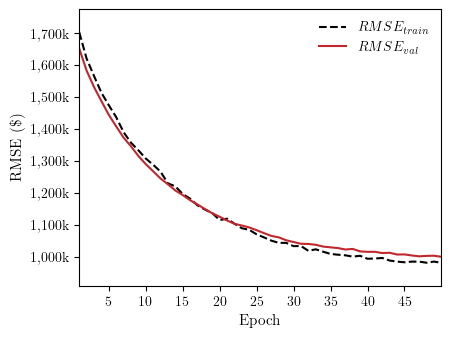

In [17]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

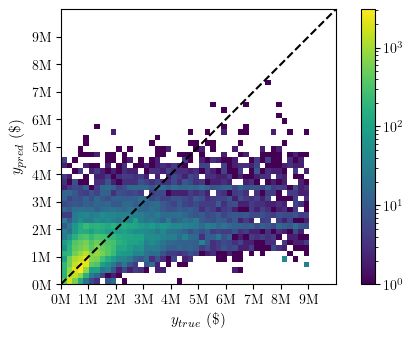

In [18]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')